# Neural Networks Project
## Self-labeled techniques for semi-supervised learning
<div style="text-align: right">
    Mark Laane <br />
    Rome, 2017
</div>

### Introduction ###
The aim of this project is to reimplement some techniques surveyed by Isaac Triguero et. al in paper [1] and to independently reproduce the reported results. A report of the project is also provided: [Project Report](Project Report Mark Laane.pdf)

Two self-labeled techniques are chosen from the paper: Standard Self-Training and Tri-Training. Those techniques are used on Abalone and Dermatology datasets. For implementation, Python programming language was chosen along with Pandas and Sclearn libraries.

### Datasets ###
Two standard datasets are used: Abalone and Dermatology. The datasets are loaded from mldata.org

In [1]:
#Datasets are stored in a python dictionary
datasets = {}

from sklearn.datasets import fetch_mldata
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Fetch abalone dataset from mldata.org
data = fetch_mldata("abalone")
# Preprocessing pipe for abalone dataset encodes categorical feature
# and scales the features
preprocessing_pipe = make_pipeline(
    #OneHotEncoder on "Sex" feature
    OneHotEncoder(categorical_features=[0], sparse=False),
    #Scale all from 0 to 1
    MinMaxScaler())
# Apply preprocessing pipe to dataset and store the dataset in dict.
datasets["abalone"] = {
    "X": preprocessing_pipe.fit_transform(data.data),
    "y": data.target
}

In [2]:
#Dermatology dataset is loaded from mldata.org and used as-is
data = fetch_mldata("uci-20070111 dermatology")
datasets["dermatology"] = {
    "X": data.data[:,0:-1],
    "y": data.data[:,-1]
}

### Base classifiers ###
3 different base classifiers are used. The base classifiers are provided by Sklearn library. The classifiers are configured according to the parameters described in the paper.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Class that only holds a collection of different 
# base classifiers for usage with SSL methods.
class base_classifiers:
    KNN = KNeighborsClassifier(
        n_neighbors=3,
        metric="euclidean",
        #n_jobs=2  # Parallelize work on CPUs
    )
    NB = GaussianNB(
        priors=None
    )
    #SVM = SVC(
    #    C=1.0,
    #    kernel='poly',
    #    degree=1,
    #    tol=0.001,
    #)
    CART = DecisionTreeClassifier(
        criterion='entropy',
        # splitter='best',
        # max_depth=None,
        # min_samples_split=2,
        min_samples_leaf=2,
        # min_weight_fraction_leaf=0.0,
        # max_features=None,
        # random_state=None,
        # max_leaf_nodes=None,
        # min_impurity_split=1e-07,
        # class_weight=None,
        # presort=False,
    )

### Implemented self-labeled algorithms ###
Two algorithms are implemented: Standard Self-Training and Tri Training.
#### Standard Self-Training ####
Implementation: [Standard Self-Training](standard_self_training.py)<br />
The implementation is based on description of the algorithm in paper [2].
Training an Standard Self-Training classifier is an iterative process - The base classifier is trained with initial labeled samples. Then it is used for labelling the unlabelled samples and the classifier is retrained with the most confident predictions. The process is repeated until the classifier output stabilizes.
#### Tri-Training ###
Implementation: [Tri-Training](tri_training.py)<br />
The implementation is based on description of the algorithm in paper [3].
In Tri-Training, Three base classifiers is trained on randomly subsampled sets of the labelled data. Then each of them will be iteratively trained on labeled data gained from two other base classifiers. The prediciton is made by using majority voting on three base classifiers.

In total 6 different classifiers are trained - 2 techniques with 3 different base classifiers:

In [4]:
from standard_self_training import StandardSelfTraining
from tri_training import TriTraining

# All classifiers used for testing
classifiers = [
    TriTraining("TriTraining (KNN)", base_classifiers.KNN),
    TriTraining("TriTraining (NB)", base_classifiers.NB),
    #TriTraining("TriTraining (SVM)", base_classifiers.SVM),
    TriTraining("TriTraining (CART)", base_classifiers.CART),
    StandardSelfTraining("Self-Training (KNN)", base_classifiers.KNN),
    StandardSelfTraining("Self-Training (NB)", base_classifiers.NB),
    #StandardSelfTraining("Self-Training (SVM)", base_classifiers.SVM),
    StandardSelfTraining("Self-Training (CART)", base_classifiers.CART)
]
labeling_rates = [0.10, 0.20, 0.30, 0.40]

### Training and scoring ###

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

def _training_scoring_iteration(clf, X, y, training_index, test_index, labeling_rate):
    """ 
    One iteration of fully training and scoring a 
    classifier on given data (one Kfold split)
    """
    #Testing set is set aside.. - 1/10th of the data
    X_test, y_test = X[test_index], y[test_index]

    #For generating a testing and transductive set
    split_data = train_test_split(
        X[training_index],
        y[training_index],
        test_size=labeling_rate,
        random_state=42
    )
    (X_unlabeled, X_labeled, y_unlabeled, y_labeled) = split_data

    #Training set - 9/10 of data
    X_train = np.concatenate((X_labeled, X_unlabeled))
    y_train = np.concatenate((
        y_labeled.astype(str),
        np.full_like(y_unlabeled.astype(str), "unlabeled")
    ))
    
    #Train the classifier
    clf.fit(X_train, y_train)
    
    #Score the classifier
    transductive_score = clf.score(X_unlabeled, y_unlabeled.astype(str))
    testing_score = clf.score(X_test, y_test.astype(str))

    cnf_matrix = pd.DataFrame(
        confusion_matrix(y_test.astype(str), clf.predict(X_test).astype(str))
    )
    
    return transductive_score, testing_score, cnf_matrix
    
def train_and_score(clf, X, y, cv, labeling_rate):
    """
    Perform KFold cross-validation of a classifier on a given data
    and labelling rate
    """
    transductive_scores = []
    testing_scores = []
    for training_index, test_index in cv.split(X,y):
        transductive_score, testing_score, cnf_matrix = _training_scoring_iteration(clf, X, y, training_index, test_index, labeling_rate)
        
        transductive_scores.append(transductive_score)
        testing_scores.append(testing_score)
        print("#", end="")
    print()
    scores = {
        "trans_mean": np.mean(transductive_scores),
        "test_mean": np.mean(testing_scores),
        "trans_std": np.std(transductive_scores),
        "test_std": np.std(testing_scores)
    }
    return scores, cnf_matrix

In [6]:
from sklearn.model_selection import KFold
import pandas as pd

""" 
The main loop for testing 
all classifiers with 
all datasets and 
all labeling rates
"""
results = None
cnf_matrixes = {}
for classifier in classifiers:
    cnf_matrixes[classifier.name] = {}
    print(classifier.name)
    for dataset_name, dataset in datasets.items():
        cnf_matrixes[classifier.name][dataset_name] = {}
        print("dataset:", dataset_name, "\t")
        for labeling_rate in labeling_rates:
            print("rate:", labeling_rate, end=" ")

            test_info = { "classifier": classifier.name, "dataset":dataset_name, "labeling_rate":labeling_rate}
            cv = KFold(n_splits=10, random_state=42)
            scores, cnf_matrix = train_and_score(classifier, dataset["X"], dataset["y"], cv, labeling_rate)

            if results is None:
                results = pd.DataFrame([{**test_info, **scores}])
            else:
                results.loc[len(results.index)] = {**test_info, **scores}
            cnf_matrixes[classifier.name][dataset_name][labeling_rate] = cnf_matrix
    print()
    print("--------")

TriTraining (KNN)
dataset: abalone 	
rate: 0.1 ##

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


######

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#
rate: 0.2 ######

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


###
rate: 0.3 ###

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


####

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##
rate: 0.4 ###

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


###

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


###
dataset: dermatology 	
rate: 0.1 ##########
rate: 0.2 ##########
rate: 0.3 ##########
rate: 0.4 ##########

--------
TriTraining (NB)
dataset: abalone 	
rate: 0.1 ##

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


###
rate: 0.2 

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


####

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#
rate: 0.3 

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


####

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##
rate: 0.4 

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#####

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


###

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##
dataset: dermatology 	
rate: 0.1 ##########
rate: 0.2 ##########
rate: 0.3 ##

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#####

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


###
rate: 0.4 #####

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


###

--------
TriTraining (CART)
dataset: abalone 	
rate: 0.1 ###

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


######

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


#
rate: 0.2 ########

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


##
rate: 0.3 ##########
rate: 0.4 ######

/home/mark/.local/lib/python3.5/site-packages/numpy/ma/core.py:3883: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = self.filled(0).__eq__(other)
/home/mark/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


####
dataset: dermatology 	
rate: 0.1 ##########
rate: 0.2 ##########
rate: 0.3 ##########
rate: 0.4 ##########

--------
Self-Training (KNN)
dataset: abalone 	
rate: 0.1 35#28#27#30#26#30#36#29#29#36#
rate: 0.2 30#39#29#24#27#33#34#29#31#31#
rate: 0.3 25#26#25#26#22#21#23#27#30#28#
rate: 0.4 23#20#19#19#20#22#24#21#21#21#
dataset: dermatology 	
rate: 0.1 16#10#10#15#12#11#13#11#15#14#
rate: 0.2 19#14#10#15#11#10#12#9#8#17#
rate: 0.3 14#13#10#10#10#8#11#9#10#8#
rate: 0.4 7#8#8#10#11#10#9#7#9#8#

--------
Self-Training (NB)
dataset: abalone 	
rate: 0.1 19#20#10#12#9#22#19#13#29#16#
rate: 0.2 9#15#28#29#33#37#40#40#37#40#
rate: 0.3 39#20#37#40#40#40#40#40#40#40#
rate: 0.4 40#40#40#40#40#40#40#40#40#40#
dataset: dermatology 	
rate: 0.1 1#1#1#3#1#1#1#1#26#28#
rate: 0.2 2#40#40#40#40#40#40#40#40#36#
rate: 0.3 40#40#40#40#40#40#40#40#40#40#
rate: 0.4 40#40#40#40#40#40#40#40#40#40#

--------
Self-Training (CART)
dataset: abalone 	
rate: 0.1 19#21#19#21#16#12#25#19#15#20#
rate: 0.2 23#23#27#20

### Results ###

In [7]:
results

,classifier,dataset,labeling_rate,test_mean,test_std,trans_mean,trans_std
0,TriTraining (KNN),abalone,0.1,0.159610,0.093613,0.186119,0.063314
1,TriTraining (KNN),abalone,0.2,0.185034,0.084115,0.167961,0.084159
2,TriTraining (KNN),abalone,0.3,0.152725,0.092253,0.186408,0.063170
3,TriTraining (KNN),abalone,0.4,0.146791,0.085206,0.182644,0.061573
4,TriTraining (KNN),dermatology,0.1,0.478078,0.061992,0.443366,0.035022
5,TriTraining (KNN),dermatology,0.2,0.647748,0.070364,0.668955,0.020381
6,TriTraining (KNN),dermatology,0.3,0.737913,0.080060,0.744788,0.015202
7,TriTraining (KNN),dermatology,0.4,0.773348,0.083499,0.800413,0.033052
8,TriTraining (NB),abalone,0.1,0.090718,0.035779,0.044423,0.044664
9,TriTraining (NB),abalone,0.2,0.085693,0.053914,0.043761,0.053617


In [8]:
pd.pivot_table(results, values=None, index=['dataset', 'classifier'], columns=['labeling_rate'])

test_mean                                \
labeling_rate                          0.1       0.2       0.3       0.4   
dataset     classifier                                                     
abalone     Self-Training (CART)  0.208044  0.212577  0.209482  0.212609   
            Self-Training (KNN)   0.242754  0.230311  0.229596  0.227203   
            Self-Training (NB)    0.075651  0.086187  0.091458  0.091689   
            TriTraining (CART)    0.167789  0.197977  0.192957  0.169758   
            TriTraining (KNN)     0.159610  0.185034  0.152725  0.146791   
            TriTraining (NB)      0.090718  0.085693  0.090472  0.088085   
dermatology Self-Training (CART)  0.778153  0.879730  0.877102  0.909835   
            Self-Training (KNN)   0.549399  0.696772  0.748574  0.781381   
            Self-Training (NB)    0.676877  0.196396  0.196396  0.196396   
            TriTraining (CART)    0.715766  0.896321  0.901727  0.907132   
            TriTraining (KNN)     0.478078  0.647748  0.737913  0.773348   
            TriTraining (NB)      0.401126  0.278153  0.166366  0.155030   

                                  test_std                                \
labeling_rate                          0.1       0.2       0.3       0.4   
dataset     classifier                                                     
abalone     Self-Training (CART)  0.057041  0.058447  0.045617  0.051943   
            Self-Training (KNN)   0.084157  0.083290  0.073373  0.074212   
            Self-Training (NB)    0.023860  0.033949  0.036784  0.040028   
            TriTraining (CART)    0.080768  0.063281  0.041478  0.070042   
            TriTraining (KNN)     0.093613  0.084115  0.092253  0.085206   
            TriTraining (NB)      0.035779  0.053914  0.058631  0.057578   
dermatology Self-Training (CART)  0.107618  0.089891  0.071579  0.068335   
            Self-Training (KNN)   0.072864  0.045663  0.053008  0.057703   
            Self-Training (NB)    0.250911  0.069305  0.069305  0.069305   
            TriTraining (CART)    0.152987  0.074975  0.068320  0.064047   
            TriTraining (KNN)     0.061992  0.070364  0.080060  0.083499   
            TriTraining (NB)      0.300181  0.210628  0.116880  0.097225   

                                 trans_mean                                \
labeling_rate                           0.1       0.2       0.3       0.4   
dataset     classifier                                                      
abalone     Self-Training (CART)   0.210919  0.210920  0.211227  0.210881   
            Self-Training (KNN)    0.237461  0.233099  0.232699  0.226223   
            Self-Training (NB)     0.065025  0.085060  0.084710  0.083315   
            TriTraining (CART)     0.181449  0.178936  0.197925  0.198067   
            TriTraining (KNN)      0.186119  0.167961  0.186408  0.182644   
            TriTraining (NB)       0.044423  0.043761  0.057842  0.082292   
dermatology Self-Training (CART)   0.790551  0.911953  0.901929  0.935674   
            Self-Training (KNN)    0.506809  0.692879  0.737414  0.785715   
            Self-Training (NB)     0.645830  0.194363  0.215726  0.223930   
            TriTraining (CART)     0.769580  0.918764  0.916243  0.946829   
            TriTraining (KNN)      0.443366  0.668955  0.744788  0.800413   
            TriTraining (NB)       0.406665  0.251790  0.196640  0.180885   

                                 trans_std                                
labeling_rate                          0.1       0.2       0.3       0.4  
dataset     classifier                                                    
abalone     Self-Training (CART)  0.012029  0.010081  0.010464  0.015029  
            Self-Training (KNN)   0.007264  0.011785  0.008617  0.008845  
            Self-Training (NB)    0.004766  0.010414  0.006705  0.005651  
            TriTraining (CART)    0.061071  0.060470  0.011228  0.009981  
            TriTraining (KNN)     0.063314  0.084159  0.063170  0.0615

------
[1]: Isaac Triguero et. al "Self-labeled techniques for semi-supervised learning:taxonomy, software and empirical study" 2015

[2]: Yarowsky D (1995) Unsupervised word sense disambiguation rivaling supervised methods. In: Proceedings
of the 33rd annual meeting of the association for computational linguistics, pp 189–196

[3]: Zhou ZH, Li M (2005) Tri-training: exploiting unlabeled data using three classifiers. IEEE Trans Knowl
Data Eng 17:1529–1541

Self-Training (CART) dermatology  Labeling ratio: 0.4


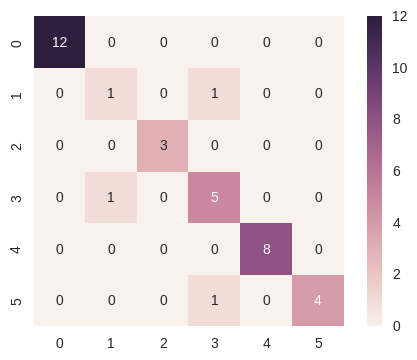

Self-Training (CART) abalone  Labeling ratio: 0.4


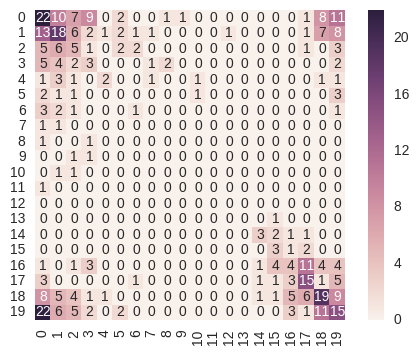

TriTraining (NB) dermatology  Labeling ratio: 0.4


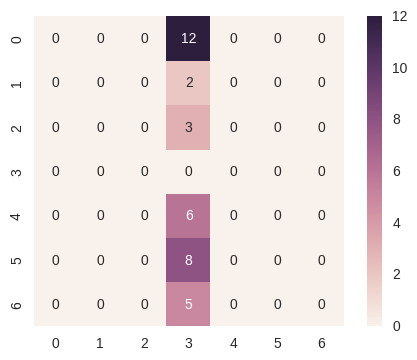

Self-Training (NB) abalone  Labeling ratio: 0.4


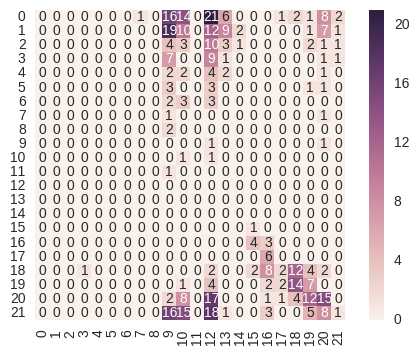

Self-Training (KNN) dermatology  Labeling ratio: 0.4


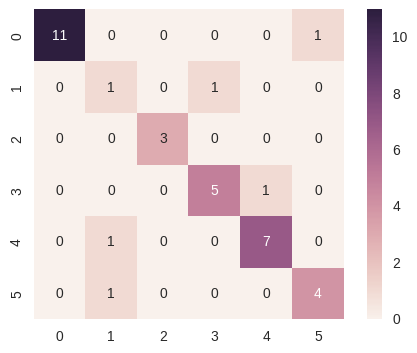

In [17]:
import seaborn as sns
%matplotlib inline

cnf_matrixes_to_show ={
    ("Self-Training (CART)", "dermatology", 0.4),
    ("Self-Training (KNN)", "dermatology", 0.4),
    ("Self-Training (CART)", "abalone", 0.4),
    ("Self-Training (NB)", "abalone", 0.4),
    ("TriTraining (NB)", "dermatology", 0.4),
}
for classifier, dataset, ratio in cnf_matrixes_to_show:
    matrix = cnf_matrixes[classifier][dataset][ratio]
    print(classifier, dataset," Labeling ratio:",ratio)
    #print(matrix)
    sns.heatmap(matrix,annot=True, square=True)
    sns.plt.show()